In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pylab import rc, plot

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

cmap = sns.diverging_palette(220, 10, as_cmap=True) # цветовая палитра для seaborn 

%matplotlib inline
pd.get_option("display.max_columns")

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot

N, M, R_min, R_max = количество классов(4), количество элементов в классе(812), диапазон значений точности(мин = .800, мах = .849)

In [ ]:
N, M, R_min, R_max = 4, 812*4, .800, .849

In [ ]:
# Генерация четырех классов, каждый из которых представим в виде двух признаков
 
X, y = make_blobs(n_samples=M, centers=N, n_features=2,
                  cluster_std = 1.85,
                   random_state=0)
 
# first_feature, second_feature - признаки; target_value - метка класса
columns = {'first_feature': X[:, 0], 'second_feature': X[:, 1], 'target_value': y}
data = pd.DataFrame(data = columns)
data.head(10)

,first_feature,second_feature,target_value
0,-0.009318,2.256571,2
1,-0.453358,5.935592,0
2,-0.708059,8.048030,3
3,1.949856,0.164721,1
4,3.060547,2.305914,0
5,-1.977568,6.652780,3
6,1.067836,5.217385,0
7,-1.324925,10.380952,3
8,-0.656389,2.481644,2
9,-1.853315,-0.103972,2


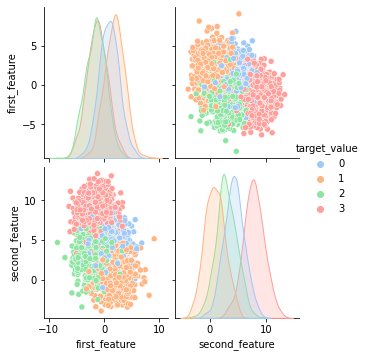

In [ ]:
# визуализация данных

g = sns.pairplot(data, hue='target_value', palette='pastel')
g.fig.set_size_inches(5,5)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
# параметры для дерева решений
params = dict(max_depth = np.linspace(1, 32, 32, endpoint=True), 
                      min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True),
                      min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
                      )
# признаки и целевая переменная (метка класса)
values, targets = data.drop('target_value', axis=1), data.target_value
# разбиение на train-test 
x_train, x_test, y_train, y_test = train_test_split(data.drop('target_value', axis=1), data.target_value, test_size=0.5, stratify=data.target_value, random_state=42)

In [ ]:
# используем refit='recall_macro', так как recall = TP / (TP + FN)
# минимизируем ошибку второго рода (FN)
# чем меньше значение FN, тем больше значение recall
# чем выше recall, тем меньше ложных пропусков -> меньше ошибка второго рода

def do_random_search(model=None, refit='recall_macro', params=params, values=values, tagrets=targets):

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
    random_search_cv = RandomizedSearchCV(model, params, scoring=['f1_macro','precision_macro', 'recall_macro'], 
                                          n_jobs=4, cv=cv, verbose=3, random_state=42, refit=refit)
    random_search = random_search_cv.fit(values, targets)
    print('Best params for {}'.format(refit))
    print(random_search.best_params_)

In [ ]:
def do_grid_search(model=None, refit='recall_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test):
    
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
    grid_search = GridSearchCV(model, params, scoring=['f1_macro','precision_macro', 'recall_macro'], 
                                n_jobs=4, cv=cv, verbose=3, refit=refit) 
    grid_search.fit(x_train.values, y_train.values)
    y_pred = grid_search.predict(x_test.values)
    print('Best params for {}'.format(refit))
    print(grid_search.best_params_)


In [ ]:
def print_result(y_test=y_test, pred=None):
  
  print("classification report: \n", classification_report(y_test, pred))
  conf_matrix = confusion_matrix(y_test, pred)
  print("Матрица ошибок: \n", conf_matrix, "\n")
  sns.heatmap(conf_matrix, cmap = cmap, annot=True)

Desicion tree

In [ ]:
dtree = DecisionTreeClassifier(random_state=42)
score = cross_val_score(dtree, data.drop('target_value', axis=1), data.target_value, cv=9, scoring='recall_macro')
print('Средняя оценка recall без настройки гиперпараметров: ', np.mean(score))

Средняя оценка recall без настройки гиперпараметров:  0.6176197259530594


classification report: 
               precision    recall  f1-score   support

           0       0.48      0.44      0.46       406
           1       0.67      0.68      0.67       406
           2       0.57      0.58      0.57       406
           3       0.76      0.80      0.78       406

    accuracy                           0.62      1624
   macro avg       0.62      0.62      0.62      1624
weighted avg       0.62      0.62      0.62      1624

Матрица ошибок: 
 [[178  83  81  64]
 [ 65 276  63   2]
 [ 82  54 234  36]
 [ 47   1  35 323]] 



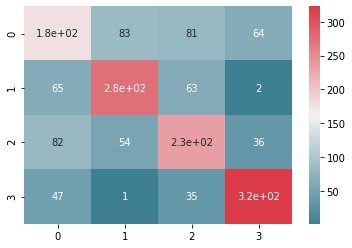

In [ ]:
dtree.fit(x_train, y_train)
pred = dtree.predict(x_test)
print_result(y_test=y_test, pred=pred)

In [ ]:
%%time
do_random_search(model=dtree, refit='recall_macro', params=params, values=values, tagrets=targets)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.5s


Best params for recall_macro
{'min_samples_split': 0.09000000000000001, 'min_samples_leaf': 0.04000000000000001, 'max_depth': 17.0}
CPU times: user 236 ms, sys: 39.8 ms, total: 276 ms
Wall time: 2.75 s


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.7s finished


RandomSearchCV дал следующие значения гиперпараметров: 

**{'min_samples_split': 0.09000000000000001, 'min_samples_leaf': 0.0400000000000001, 'max_depth': 17.0}**

Затраченное время: 
- CPU times: user 236 ms, sys: 39.8 ms, total: 276 ms
- Wall time: 2.75 s

In [ ]:
dtree_random = DecisionTreeClassifier(random_state=42, max_depth=12.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.01)

score = cross_val_score(dtree_random, data.drop('target_value', axis=1), data.target_value, cv=9, scoring='recall_macro')
print('Средняя оценка recall с настройкой гиперпараметров RandomSearch: ', np.mean(score))

Средняя оценка recall с настройкой гиперпараметров RandomSearch:  0.6982905982905983


classification report: 
               precision    recall  f1-score   support

           0       0.58      0.39      0.46       406
           1       0.68      0.76      0.72       406
           2       0.61      0.70      0.65       406
           3       0.79      0.86      0.83       406

    accuracy                           0.68      1624
   macro avg       0.67      0.68      0.67      1624
weighted avg       0.67      0.68      0.67      1624

Матрица ошибок: 
 [[157  90  90  69]
 [ 28 308  70   0]
 [ 47  53 283  23]
 [ 38   0  18 350]] 



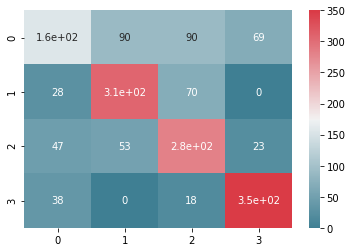

In [ ]:
dtree_random.fit(x_train, y_train)
pred_random_search = dtree_random.predict(x_test)
print_result(y_test=y_test, pred=pred_random_search)

Визуализация деерва решений с настройкой гиперпараметров RandomSearch

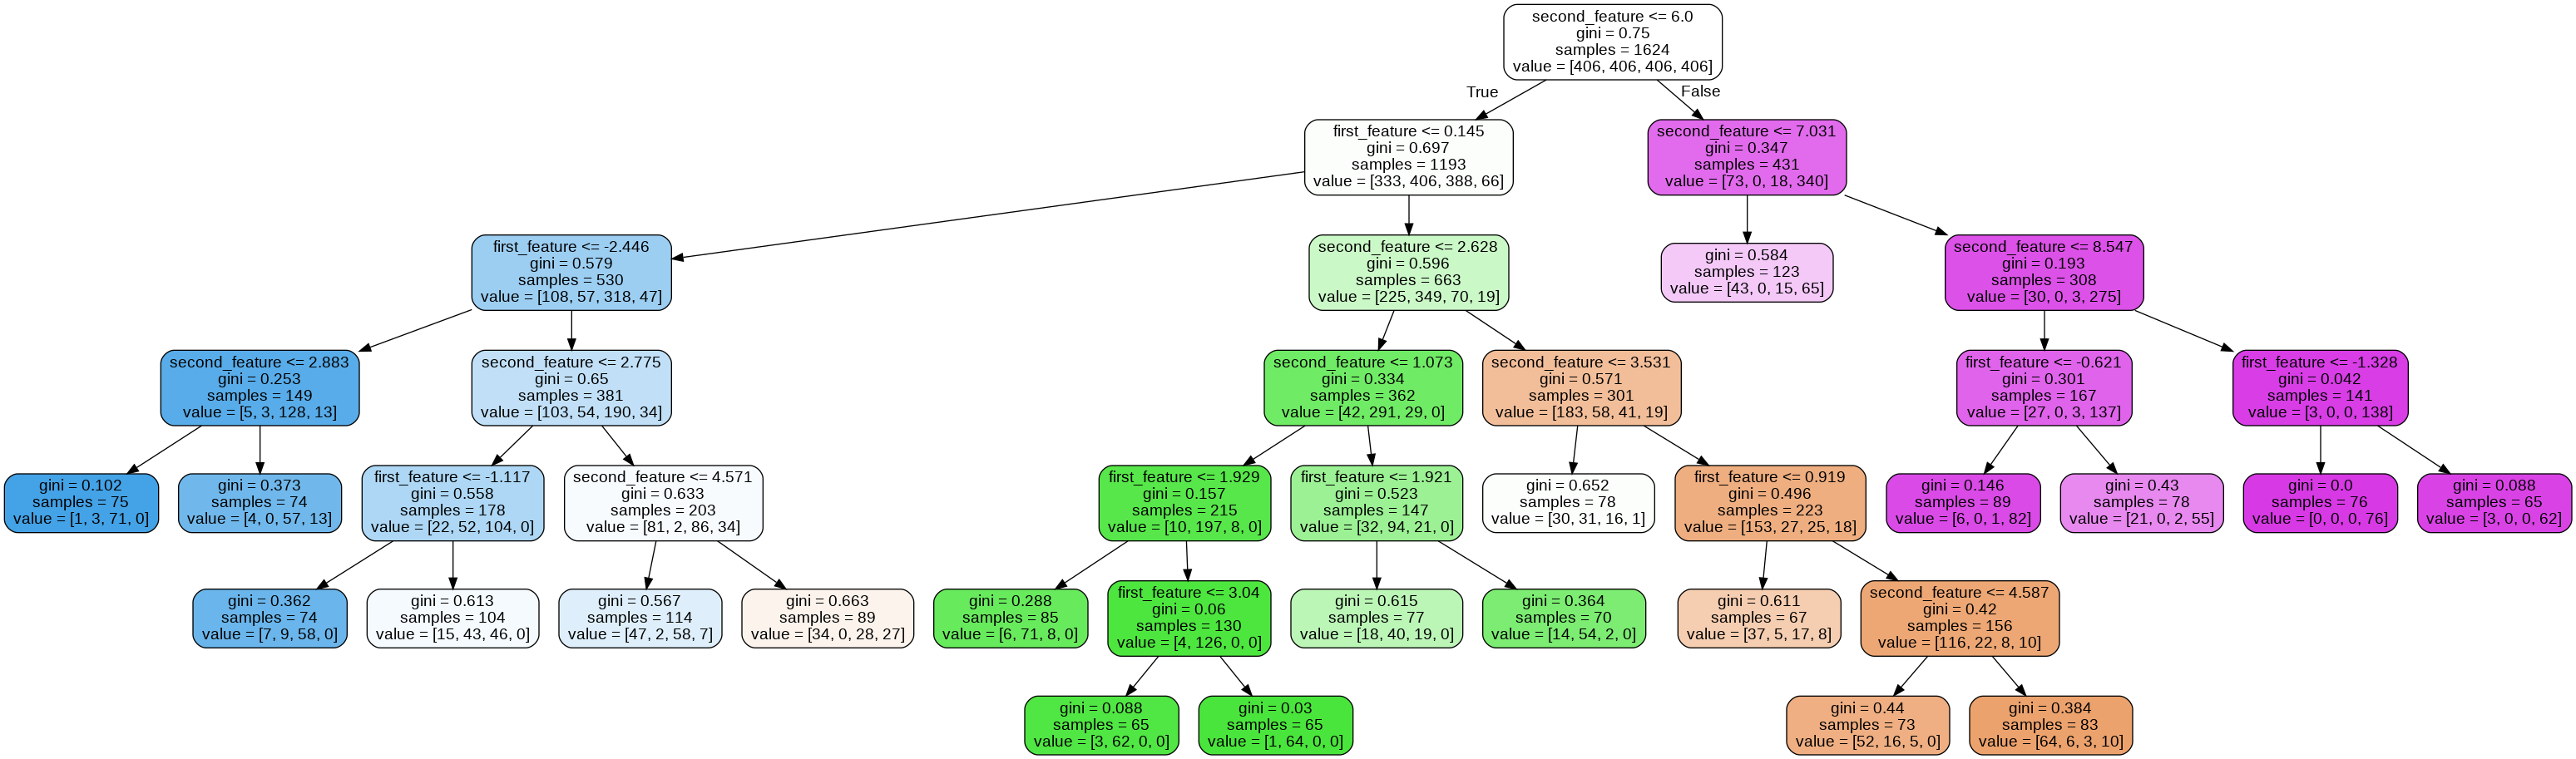

In [ ]:
features = list(values.columns)
dot_data = StringIO()
export_graphviz(dtree_random, out_file=dot_data, feature_names=features, filled=True, rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

GridSearchCV

In [ ]:
%%time
do_grid_search(model=dtree, refit='recall_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1528 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 4088 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 7672 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done 12280 tasks      | elapsed:   52.7s


Best params for recall_macro
{'max_depth': 6.0, 'min_samples_leaf': 0.020000000000000004, 'min_samples_split': 0.01}
CPU times: user 12.5 s, sys: 174 ms, total: 12.7 s
Wall time: 1min 8s


[Parallel(n_jobs=4)]: Done 16000 out of 16000 | elapsed:  1.1min finished


In [ ]:
dtree_grid = DecisionTreeClassifier(random_state=42, max_depth=6.0, min_samples_leaf=0.01, min_samples_split=0.030000000000000006)

score = cross_val_score(dtree_grid, values, targets, cv=9, scoring='recall_macro')
print('Средняя оценка recall с настройкой гиперпараметров GridSearch: ', np.mean(score))

Средняя оценка recall с настройкой гиперпараметров GridSearch:  0.6945665445665445


classification report: 
               precision    recall  f1-score   support

           0       0.60      0.56      0.58       406
           1       0.74      0.78      0.76       406
           2       0.67      0.64      0.66       406
           3       0.80      0.87      0.83       406

    accuracy                           0.71      1624
   macro avg       0.70      0.71      0.71      1624
weighted avg       0.70      0.71      0.71      1624

Матрица ошибок: 
 [[226  63  62  55]
 [ 47 315  44   0]
 [ 66  49 259  32]
 [ 35   0  19 352]] 



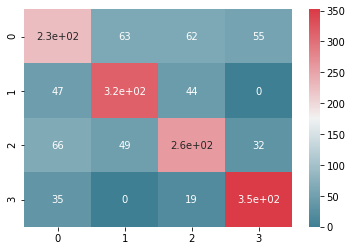

In [ ]:
dtree_grid.fit(x_train, y_train)
pred_grid_search = dtree_grid.predict(x_test)
print_result(y_test, pred_grid_search)

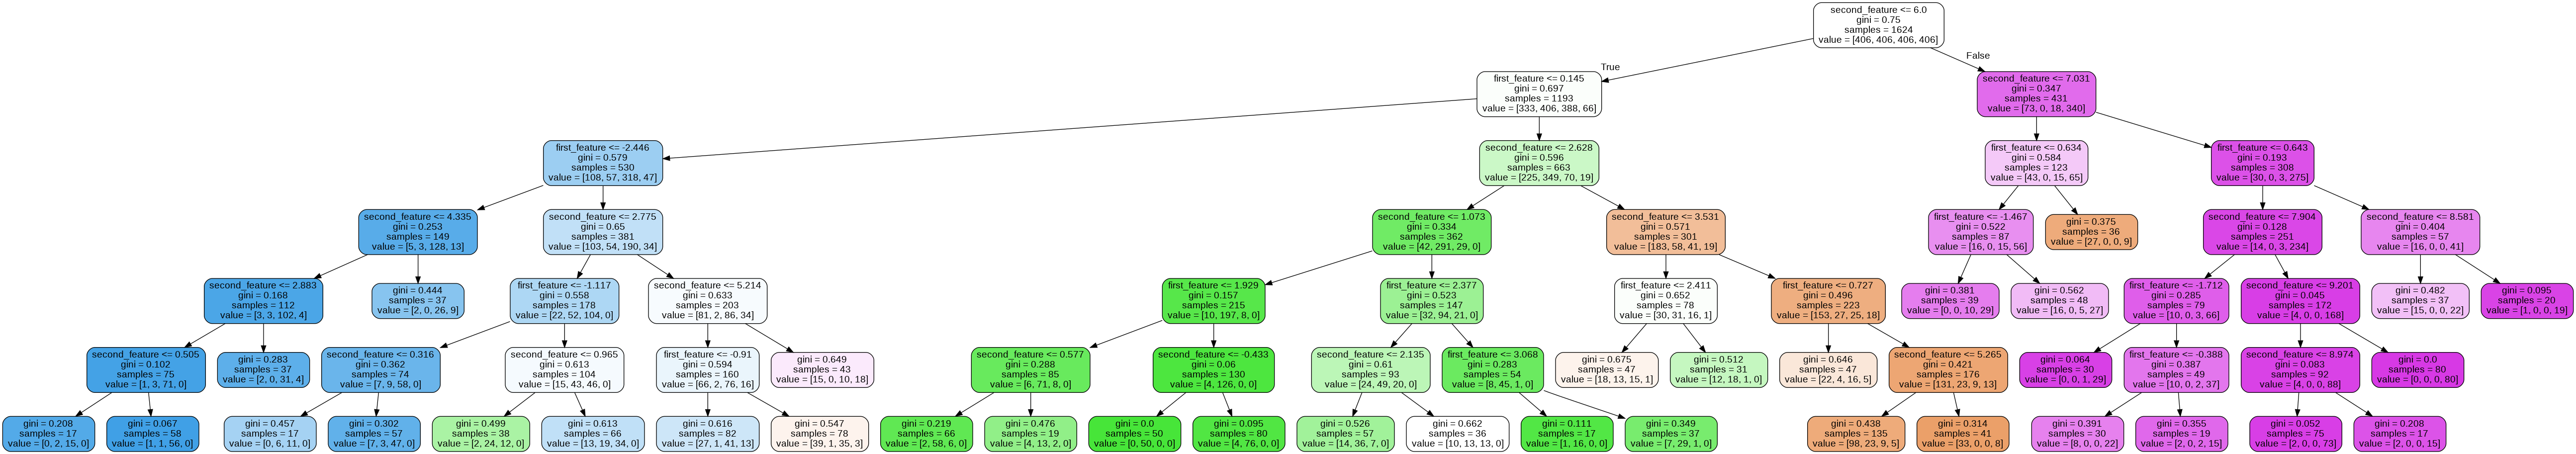

In [ ]:
features = list(values.columns)
dot_data = StringIO()
export_graphviz(dtree_grid, out_file=dot_data, feature_names=features, filled=True, rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())